# Full Python API example of ptdalgorithms
This notebook will describe almost all functions of the ptdalgorithms Python package. The core functionality is implemented in C, with a binding layer to Python through C++ and pybind11. Except for the specified construction code of the state space, most code will be almost equally fast to invoking the C api directly (maybe twice as slow). The package is based on graph algorithms published in (...), and is many orders of magnitude faster than matrix-based equations which are usually applied. We do not recommend using the C++ api directly.

We will show how to install the package and construct a state space through the Python api. We will then show how to compute the moments (expectation, variance) through the ptdalgorithms package, and how to compute the distribution functions. This means that you can make discrete and continuous phase-type distributions, compute their moments, distribution functions, sample from them, compute rewards and multivariate distributions, and time inhomogenous distributions.

We will also show how easy it is to create the state-space in C and return it to Python, to make large graphs!

## Installing the ptdalgorithms library

Using conda (recommended):

```txt
conda install -c conda-forge -c munch-group ptdalgorithms
```

Using pip:

```txt
pip install ptdalgorithms
```

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')
import matplotlib
matplotlib.rcParams['axes.facecolor'] = '#1F1F1F'
matplotlib.rcParams['figure.facecolor'] = '#1F1F1F'

#%matplotlib widget

%config InlineBackend.figure_format = 'retina'

import ptdalgorithms as ptd

# State-space construction

In [2]:
def c(*args):
    elem = []
    for arg in args:
        if hasattr(arg, '__len__') and len(arg) > 1:
            elem.extend(arg)
        else:
            elem.append(arg)
    return np.array(elem)

In [3]:
def print_states(vertex):
    print(vertex.state())
    for edge in vertex.edges():
        print(" ", edge.weight() , "->", edge.to().state())    

This phase-type distribution models the time until all rabits have died We can find the expectation, variance, moments

In [4]:
number_of_rabbits, flooding_rate_l, flooding_rate_r = 2, 2, 4

# we represent the vector as two integers, the number of 
# rabbits on the left and right island
state_vector_length = 2
graph = ptd.Graph(state_vector_length)

# the initial state is the only starting state, with probability 1
initial_state = c(number_of_rabbits, 0)
vertex = graph.find_or_create_vertex(initial_state)
graph.starting_vertex().add_edge(vertex, 1)

index = 1
# iterate over all unvisited vertices
while index < graph.vertices_length():
    vertex = graph.vertex_at(index)
    state = vertex.state()
    
    if state[0] > 0:
        # rabbit jump left to right
        child_state = c(state[0] - 1, state[1] + 1)
        vertex.add_edge(
            graph.find_or_create_vertex(child_state),
            weight=1
        )
        # left island flooding
        child_state = c(0, state[1])
        vertex.add_edge(
            graph.find_or_create_vertex(child_state), 
            weight=flooding_rate_l
        )
    if state[1] > 0:   
        child_state = c(state[0] + 1, state[1] - 1)
        vertex.add_edge(
            graph.find_or_create_vertex(child_state),
            weight=1
        )
        # right island flooding
        child_state = c(state[0], 0)
        vertex.add_edge(
            graph.find_or_create_vertex(child_state), 
            weight=flooding_rate_r
        )

    print_states(vertex)

    index += 1
    
graph.states()

[2, 0]
  1.0 -> [1, 1]
  2.0 -> [0, 0]
[1, 1]
  1.0 -> [0, 2]
  2.0 -> [0, 1]
  1.0 -> [2, 0]
  4.0 -> [1, 0]
[0, 0]
[0, 2]
  1.0 -> [1, 1]
  4.0 -> [0, 0]
[0, 1]
  1.0 -> [1, 0]
  4.0 -> [0, 0]
[1, 0]
  1.0 -> [0, 1]
  2.0 -> [0, 0]


array([[0, 0],
       [2, 0],
       [1, 1],
       [0, 0],
       [0, 2],
       [0, 1],
       [1, 0]], dtype=int32)

In [5]:
def construct_rabbit_graph(n, flrl, flrr):

    g = ptd.Graph(2)
    g.starting_vertex().add_edge(g.focv(c(n, 0)), 1)
    i = 1
    while i < g.vertices_length():
        v = g.vertex_at(i)
        st = v.state()
        if st[0] > 0:
            v.ae(g.focv([st[0]-1, st[1]+1]), 1)
            v.ae(g.focv([0, st[1]]), flrl)
        if st[1] > 0:   
            v.ae(g.focv([st[0]+1, st[1]-1]), 1)
            v.ae(g.focv([st[0], 0]), flrr)
        i += 1

    return graph
    
    
graph = construct_rabbit_graph(2, 2, 4)

graph.states()

array([[0, 0],
       [2, 0],
       [1, 1],
       [0, 0],
       [0, 2],
       [0, 1],
       [1, 0]], dtype=int32)

## Example of rabbit graph

![Example of rabbit graph](https://github.com/TobiasRoikjer/PtDAlgorithms/blob/master/examples/graphic_rabbits.png?raw=true)

## Continuous phase-type distribution

We can now construct the graphs by the function. The flooding rates are set to 2 and 4

In [6]:
graph = construct_rabbit_graph(2, 2, 4)

Get the number of vertices in the graph:

In [7]:
graph.vertices_length()

7

as well as integer vector states that those vertices represent:

In [8]:
M = graph.states()
M

array([[0, 0],
       [2, 0],
       [1, 1],
       [0, 0],
       [0, 2],
       [0, 1],
       [1, 0]], dtype=int32)

(or nicely as a dataframe):

In [9]:
pd.DataFrame(M, columns=["Rabbits left", "Rabbits right"]).style.hide()

Rabbits left,Rabbits right
0,0
2,0
1,1
0,0
0,2
0,1
1,0


This phase-type distribution models the time until all rabits have died. For convenience, we can get its expectation and variance like this:

In [10]:
graph.expectation()

INFO: building reward compute graph...


0.5038265306122448

In [11]:
graph.variance()

0.2264567497917534

But if you want you can get any number of moments like this (here three):

In [12]:
graph.moments(3)

[0.5038265306122448, 0.48029792274052463, 0.6559101757731152]

We can find the expected waiting time given that we start in any of the states, not just the starting state:        

In [13]:
graph.expected_waiting_time()

[0.5038265306122448,
 0.5038265306122448,
 0.5114795918367347,
 0.0,
 0.3022959183673469,
 0.28571428571428564,
 0.4285714285714285]

If needed for downstream analysis, matrix-based representation of the phase-type distribution can be extracted. Note that the indices in this representatoin do *not* correspond to vertex indicies in the graph.

# this makes the kernel die...

In [14]:
# graph.as_matrices()

We can get the CDF and PDF. The distribution methods reuse cached computations and recompute only if the graph changes. Compare the running times for the first and second call to the function:

In [15]:
time = np.arange(0, 4, 0.001)

In [16]:
%%time
cdf = graph.cdf(time)

CPU times: user 497 μs, sys: 39 μs, total: 536 μs
Wall time: 607 μs


In [17]:
%%time
cdf = graph.cdf(time)

CPU times: user 43 μs, sys: 12 μs, total: 55 μs
Wall time: 49.4 μs


In [18]:
%%time
pdf = graph.pdf(time)

CPU times: user 54 μs, sys: 9 μs, total: 63 μs
Wall time: 62.2 μs


PDF and CDF of distribution. Observe the long tails!

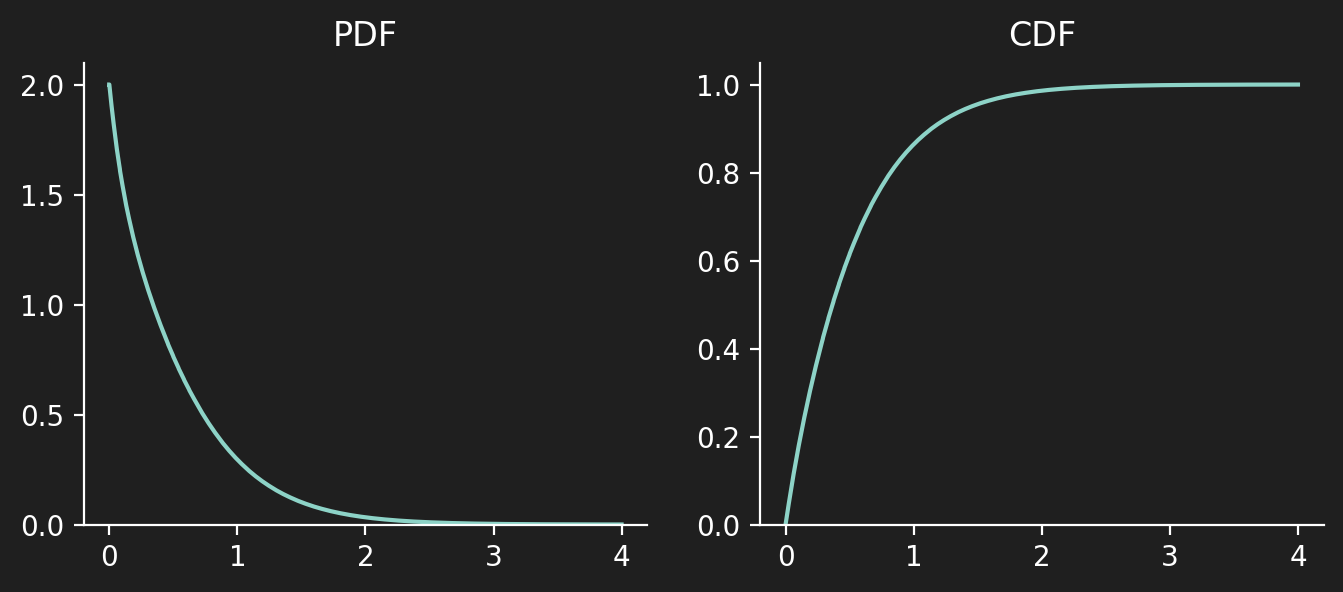

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(time, pdf)
ax1.set_title("PDF")
ax1.set_ylim(bottom=0)
ax2.plot(time, cdf)
ax2.set_title("CDF")
ax2.set_ylim(bottom=0)
sns.despine()


## Rewards

We can add rewards which are based on the number of rabbits on the second island.

In [20]:
rewards = graph.states()[:, 1]

Can also be computed like this:

In [21]:
rewards = np.array([graph.vertex_at(i).state()[1] for i in range(graph.vertices_length())])

Adding these rewards, the phase-type distribution now represent the total accumulated time that any rabbits spends on the right island.

Using rewards to the moment functions etc. is much faster than changing the graph.

The expectation and variance are now:

In [22]:
graph.expectation(rewards), graph.variance(rewards)

(0.09438775510204081, 0.04634787588504789)

Using rewards to the moment functions etc. is much faster than actually changing the graph, but sometimes we might want to be interested in reward transforming the phase-type distribution, giving us the full distribution of accumulated rewards. For example if we want the pdf/cdf.

In [23]:
right_graph = graph.reward_transform(rewards)

Now we get the expectation and variance from before without adding any rewards:

In [24]:
right_graph.expectation(), right_graph.variance()

INFO: building reward compute graph...


(0.09438775510204078, 0.046347875885047865)

We can find the distribution function for the the total accumulate time spent by any rabbit on an island. We show here the PDF and CDF

In [25]:
accumulated_rewards = np.arange(0, 2, 0.01)

pdf = right_graph.pdf(accumulated_rewards)
cdf = right_graph.cdf(accumulated_rewards)

PDF and CDF of distribution. Notice how we have a "defect" i.e. a probability of obtaining no rewards:

In [26]:
right_graph.defect()

0.6666666666666666

The defect is shown with a dotted line below. Remember to always consider this defect.

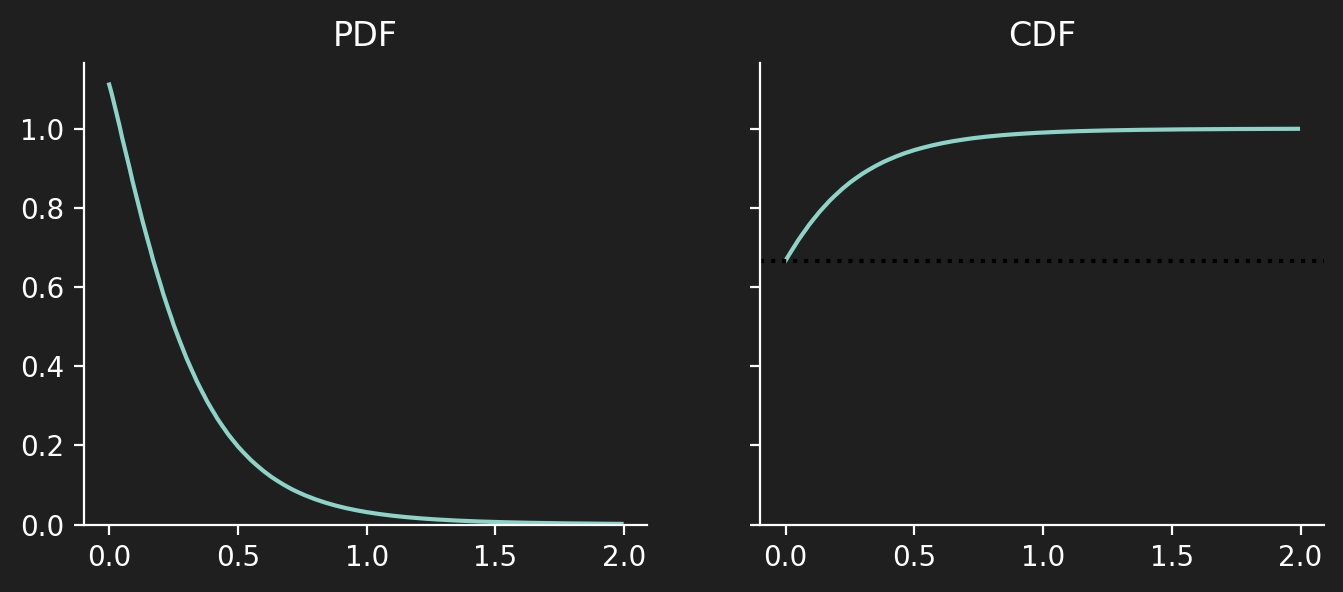

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
ax1.plot(accumulated_rewards, pdf)
ax1.set_title("PDF")
ax1.set_ylim(bottom=0)
ax2.plot(accumulated_rewards, cdf)
ax2.set_title("CDF")
ax2.set_ylim(bottom=0)
ax2.axhline(y=right_graph.defect(), linestyle='dotted', color='black')
sns.despine()

There are also utility methods to get the stop probability i.e. probabilities of occupying each state at time t. 

In [28]:
graph.stop_probability(0.2)

[0.0,
 0.5561531639166896,
 0.07040541534825098,
 0.0,
 0.007095725804629082,
 0.016348108066650276,
 0.03374890558205247]

We can use that to compute the expected number of rabbits across time:

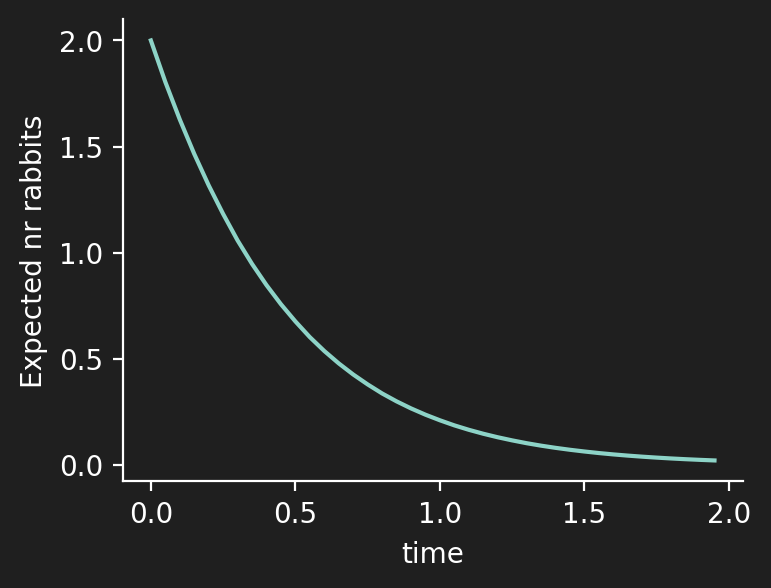

In [29]:
times = np.arange(0, 2, 0.05)
expected_rabbits_left = [
    np.sum(graph.stop_probability(i) 
           * np.sum(graph.states(), axis=1)) 
    for i in times
    ]

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(times, expected_rabbits_left)
ax.set_xlabel('time')
ax.set_ylabel("Expected nr rabbits")
sns.despine()


We can also get the accumulated visiting time of a particular state. E.g. the total time before time t=0.5 where there was a rabbit on the right island:

In [30]:
rewards = (graph.states()[:,1]>0).astype(int)
np.sum(graph.accumulated_visiting_time(time=0.5) * rewards)

np.float64(0.04053231796047568)

In [31]:
graph.expected_residence_time()

HELLO
HELLO
HELLO
HELLO
HELLO
HELLO
HELLO


[0.0, 0.5038265306122448, 0.0, 0.0, 0.0, 0.0, 0.0]

# Random sampling

The library includes functions to do random sampling. These are useful to also validate the computations

In [32]:
graph.sample(5)

[0.2960497847321067,
 0.11097817645079826,
 0.9103608328765302,
 0.4881028655685741,
 0.01824505783446474]

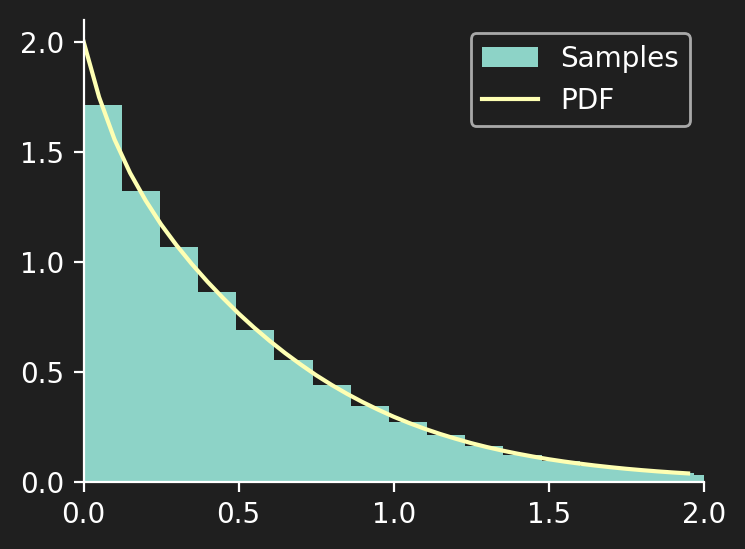

In [33]:
fig, ax = plt.subplots(figsize=(4, 3))
samples = graph.sample(1000000)

ax.hist(samples, bins=50, density=True, label='Samples')
x = np.arange(0, 2, 0.05)

ax.plot(x, [graph.pdf(t) for t in x], label='PDF')

ax.set_xlim(0, 2)
ax.legend()
sns.despine()

You can produce the moments from sampling if needed. Compare to the sampled and exact second moments:

In [34]:
np.sum(np.array(graph.sample(1000000))**2)/1000000, graph.moments(2)[1]

(np.float64(0.48146666885963857), 0.48029792274052463)

In [35]:
rewards = graph.states()[:,1]
np.sum(np.array(graph.sample(1000000, rewards))**2)/1000000, graph.moments(2, rewards)[1]

(np.float64(0.055544506884635976), 0.05525692419825073)

Reward-transforming first and then computing without rewards achieves the same thing:

In [36]:
revtr_graph = graph.reward_transform(rewards)
np.sum(np.array(revtr_graph.sample(1000000))**2)/1000000, revtr_graph.moments(2)[1]

INFO: building reward compute graph...


(np.float64(0.0556874187139037), 0.05525692419825069)

## Discrete phase-type distributions

We can also work with discrete phase-type distributions. This is the number of jumps in a Markov Chain before absorption. We will model that any rabbit can find a carrot at each time with rate 0.1 and see how many carrots the rabbits will have found. We could of course just make a new state-space creation function, but we can also manipulate existing.

In [37]:
carrot_graph = graph.clone()
vlength = carrot_graph.vertices_length()
carrot_vertices = np.repeat(False, vlength*2)


for i in range(vlength):
    vertex = carrot_graph.vertex_at(i)
    rabbits = sum(vertex.state())
    
    if rabbits > 0:
        obtained_carrot_vertex = carrot_graph.create_vertex([0])
        # Go directly back to the state we came from
        obtained_carrot_vertex.add_edge(vertex, 1)
        # Rate of finding carrot
        vertex.add_edge(obtained_carrot_vertex, rabbits * 0.1)
        carrot_vertices[obtained_carrot_vertex.index()] = True


In [38]:



vlength = carrot_graph.vertices_length()
carrot_vertices = np.repeat(False, vlength*2)

for i in range(vlength):
    vertex = carrot_graph.vertex_at(i)
    rabbits = sum(vertex.state())
    
    if rabbits > 0:
        obtained_carrot_vertex = carrot_graph.create_vertex([0])
        # Go directly back to the state we came from
        obtained_carrot_vertex.add_edge(vertex, 1)
        # Rate of finding carrot
        vertex.add_edge(obtained_carrot_vertex, rabbits * 0.1)
        carrot_vertices[obtained_carrot_vertex.index()] = True

carrot_vertices = carrot_vertices[np.arange(carrot_graph.vertices_length())]

# We now want to make the graph discrete. We do this by 'normalizing' the edges
# This is imply scaling the vertices such that the total out-going rate is 1
# As it is now the probability of transitions
weights_were_multiplied_with = carrot_graph.normalize()

print("This is the discrete state space as a sub-transition matrix:")
#carrot_graph.as_matrices()

This is the discrete state space as a sub-transition matrix:


In [43]:
from IPython.display import Image
from graphviz import Digraph

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx


for vertex in carrot_graph.vertices():
    print(vertex.index(), vertex, vertex.state(), vertex.edges())

0 <ptdalgorithms.Vertex [0, 0] [0, 0] [<ptdalgorithms.ptdalgorithmscpp_pybind.Edge object at 0x15ff891b0>]
1 <ptdalgorithms.Vertex [2, 0] [2, 0] [<ptdalgorithms.ptdalgorithmscpp_pybind.Edge object at 0x15ff891b0>, <ptdalgorithms.ptdalgorithmscpp_pybind.Edge object at 0x15ff68830>, <ptdalgorithms.ptdalgorithmscpp_pybind.Edge object at 0x15ff683f0>, <ptdalgorithms.ptdalgorithmscpp_pybind.Edge object at 0x15ff68870>]
2 <ptdalgorithms.Vertex [1, 1] [1, 1] [<ptdalgorithms.ptdalgorithmscpp_pybind.Edge object at 0x15ff891b0>, <ptdalgorithms.ptdalgorithmscpp_pybind.Edge object at 0x15ff68830>, <ptdalgorithms.ptdalgorithmscpp_pybind.Edge object at 0x15ff683f0>, <ptdalgorithms.ptdalgorithmscpp_pybind.Edge object at 0x15ff68870>, <ptdalgorithms.ptdalgorithmscpp_pybind.Edge object at 0x15ff686b0>, <ptdalgorithms.ptdalgorithmscpp_pybind.Edge object at 0x15ff686f0>]
3 <ptdalgorithms.Vertex [0, 0] [0, 0] []
4 <ptdalgorithms.Vertex [0, 2] [0, 2] [<ptdalgorithms.ptdalgorithmscpp_pybind.Edge object at 0

In [ ]:




def plot_graph(graph, constraint=True, subgraphs=False, ranksep=2, nodesep=1, splines=True, subgraphfun=lambda state, index: ','.join(map(str, state[:-1])), size=(6, 6), fontsize=10, rankdir="LR", align=False, nodecolor='white', rainbow=False, penwidth=1):
    G = nx.DiGraph()
    
    for i in range(gam['states'].shape[0]):
        G.add_node(i, label=','.join(map(str, gam['states'][i, :])))
    for i in range(gam['states'].shape[0]):
        for j in range(gam['states'].shape[0]):
            if i != j and gam['SIM'][i, j] > 0:
                G.add_edge(i, j, label=format_rate(gam['SIM'][i, j]), color=random_color(rainbow))
    pos = nx.spring_layout(G)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw(G, pos, with_labels=True, node_color=nodecolor, font_size=fontsize, node_size=500, edge_color=[G[u][v]['color'] for u, v in G.edges()])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=fontsize)
    plt.show()

plot_graph(carrot_graph)

TypeError: 'ptdalgorithms.ptdalgorithmscpp_pybind.Graph' object is not subscriptable

In [39]:
# We now want to find the expected number of eaten carrots
# We set the reward such that the carrot vertex has a reward of '1'
rewards <- as.integer(carrot_vertices)

cat(paste("DPH expectation:", dph_expectation(carrot_graph, rewards)))

# We can verify that the number of carrots correspond to scaling the continuous graph
cat(paste("\nScaled continuous expectation:", expectation(graph, rowSums(states(graph))) * 0.1))

# Of course we cannot do this for other moments!
cat(paste("\nDPH variance: ", dph_variance(carrot_graph, rewards)))
samples <- rdph(1000000, carrot_graph, rewards)

cat(paste("\nVerified by sampling: ", sum(samples^2)/1000000-((sum(samples))/1000000)^2))

SyntaxError: invalid syntax (144089476.py, line 3)

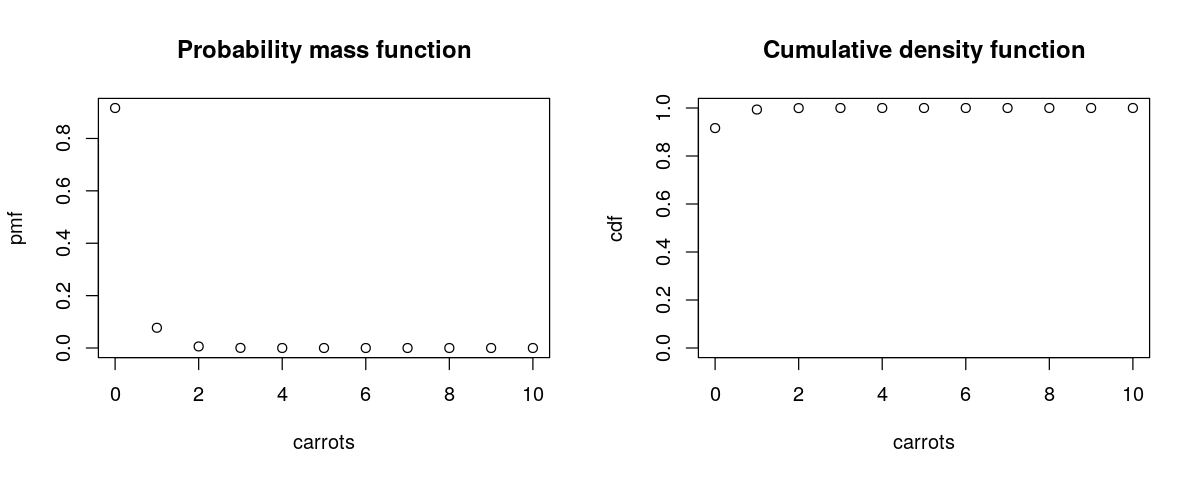

In [ ]:
# We can find the distribution function for the the total number of carrots found
carrots <- seq(0, 10)
# Notice that with this reward transformation the graph is no longer sparse, as all paths through
# the graph are represented!!
found_carrots_graph <- dph_reward_transform(carrot_graph, rewards)
pmf <- ddph(carrots, found_carrots_graph)
cdf <- pdph(carrots, found_carrots_graph)
options(repr.plot.width=10, repr.plot.height=4)
par(mfrow=c(1,2)) 
plot(carrots, pmf)
title("Probability mass function")
plot(carrots, cdf,ylim=c(0,1))
title("Cumulative density function")


# Multivariate phase-type distributions

In [ ]:
# Instead of a univariate reward, we can have the distribution earn a 
# *vector* of rewards for each time unit spent at a vertex.
# We will continue with the rabbit example. We will now show the relationship
# between total time spent by any rabbit on either of the two islands.
cat(paste("Covariance:", covariance(graph, states(graph)[,1], states(graph)[,2])))
simulations <- rmph(100000, graph, states(graph))
simulated_cov <- sum(simulations[1,]*simulations[2,])/100000 -
                    sum(simulations[1,])/100000*sum(simulations[2,])/100000
cat(paste("\nSampled covariance:", simulated_cov))

Covariance: 0.0300037744689713
Sampled covariance: 0.0294514983851195

In [ ]:
# The api also supports multivariate *discrete* phase-type distributions
# We show the covariance between carrots found on either island
mdph_carrot_graph <- clone_graph(graph)

vlength <- vertices_length(mdph_carrot_graph)
carrot_vertices_left <- rep(F, vlength*2)
carrot_vertices_right <- rep(F, vlength*2)


for (i in 1:vlength) {
    vertex <- vertex_at(mdph_carrot_graph,i)
    rabbits <- vertex$state
    
    if (rabbits[1] > 0) {
        obtained_carrot_vertex <- create_vertex(mdph_carrot_graph, 0)
        # Go directly back to the state we came from
        add_edge(obtained_carrot_vertex, vertex, 1)
        # Rate of finding carrot
        add_edge(vertex, obtained_carrot_vertex, rabbits[1] * 0.1)
        carrot_vertices_left[obtained_carrot_vertex$index] <- T
    }    
    
    
    if (rabbits[2] > 0) {
        obtained_carrot_vertex <- create_vertex(mdph_carrot_graph, 0)
        # Go directly back to the state we came from
        add_edge(obtained_carrot_vertex, vertex, 1)
        # Rate of finding carrot
        add_edge(vertex, obtained_carrot_vertex, rabbits[2] * 0.1)
        carrot_vertices_right[obtained_carrot_vertex$index] <- T
    }    
}

carrot_vertices_left <- carrot_vertices_left[1:vertices_length(mdph_carrot_graph)]
carrot_vertices_right <- carrot_vertices_right[1:vertices_length(mdph_carrot_graph)]
normalize_graph(mdph_carrot_graph) -> avoid_print
rewards <- matrix(as.integer(c(carrot_vertices_left, carrot_vertices_right)), ncol=2)
cat(paste("Covariance:", dph_covariance(mdph_carrot_graph, rewards[,1], rewards[,2])))
simulations <- rmdph(1000000, mdph_carrot_graph, rewards)
simulated_cov <- sum(simulations[1,]*simulations[2,])/1000000 -
                    sum(simulations[1,])/1000000*sum(simulations[2,])/1000000
cat(paste("\nSampled covariance:", simulated_cov))

Covariance: 0.000300037744689713
Sampled covariance: 0.000279220885

## Parameterized edges

In [ ]:
# We can *parameterize* the edges to easily update the weights of the edge
# We do this by assigning a *state* to the *edge*.
# We will now also say that the rate of rabbits jumping is proportional to the
# number of rabbits on the island.
# Our state is [rabbits able to jump, left flooding, right flooding]

construct_rabbit_graph_params <- function(number_of_rabbits) {
    # We represent the vector as two integers, the number of rabbits on the left and right island
    state_vector_length <- 2
    graph <- create_graph(state_vector_length)
    initial_state <- c(number_of_rabbits, 0)
    # The initial state is the only starting state, with 100% starting probability
    add_edge(
      starting_vertex(graph),
      find_or_create_vertex(graph, initial_state),
      1
    )
    index <- 2
    # Iterate over all unvisited vertices
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)
      state <- vertex$state
      if (state[1] > 0) {
        # Rabbit jump left to right
        child_state <- c(state[1] - 1, state[2] + 1)
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          0,
          parameterized_edge_state=c(state[1],0,0)
        )
        # Left island flooding
        child_state <- c(0, state[2])
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          0,
          parameterized_edge_state=c(0,1,0)
        )
      }
      if (state[2] > 0) {
        # Rabbit jump right to left
        child_state <- c(state[1] + 1, state[2] - 1)
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          0, 
          parameterized_edge_state=c(state[2],0,0)
        )
        # Right island flooding with rate of 4
        child_state <- c(state[1], 0)
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          0,
          parameterized_edge_state=c(0,0,1)
        )
      }
      index <- index + 1
    }
    return(graph)
}

In [ ]:
# The parameterized edges have what ever weight is assigned to them,
# and the state does not by itself mean anything.
param_graph <- construct_rabbit_graph_params(2)

# If we let the edge have a state, this gives us an easy way of changing the weights
# based on some model parameters. In this case, it is the rate of jumping
# left rate of flooding and right rate of flooding.
# The update simply takes the inner product of the state vector and
# the model parameters, e.g. if the state is x1, x2 and the parameters are p1, p2, then
# the weight of the edge becomed x1*p1+x2*p2
graph_update_weights_parameterized(param_graph, c(1, 2, 4))
cat(paste("Expectation (1,2,4):", expectation(param_graph)))
graph_update_weights_parameterized(param_graph, c(2, 2, 4))
cat(paste("\nExpectation (2,2,4):", expectation(param_graph)))
graph_update_weights_parameterized(param_graph, c(2, 4, 4))
cat(paste("\nExpectation (2,4,4):", expectation(param_graph)))
graph_update_weights_parameterized(param_graph, c(2, 4, 18))
cat(paste("\nExpectation (2,4,18):", expectation(param_graph)))
graph_update_weights_parameterized(param_graph, c(8, 4, 18))
cat(paste("\nExpectation (8,4,18):", expectation(param_graph)))

# Note that the moment graph *has* to be recalculated after updating weights

cat("\n\nSIM at 1,2,4:\n")
graph_update_weights_parameterized(param_graph, c(1, 2, 4))
print(graph_as_matrix(param_graph)$SIM)
cat("\n\nSIM at 8,4,18:\n")
graph_update_weights_parameterized(param_graph, c(8, 4, 18))
print(graph_as_matrix(param_graph)$SIM)

Expectation (1,2,4): 0.508305647840532
Expectation (2,2,4): 0.495652173913043
Expectation (2,4,4): 0.3
Expectation (2,4,18): 0.227096322687365
Expectation (8,4,18): 0.177194393695634

SIM at 1,2,4:
     [,1] [,2] [,3] [,4] [,5]
[1,]   -6    2    0    0    0
[2,]    1   -8    1    4    2
[3,]    0    2   -4    0    0
[4,]    0    0    0   -3    1
[5,]    0    0    0    1   -5


SIM at 8,4,18:
     [,1] [,2] [,3] [,4] [,5]
[1,]  -34   16    0    0    0
[2,]    8  -38    8   18    4
[3,]    0   16  -20    0    0
[4,]    0    0    0  -12    8
[5,]    0    0    0    8  -26


## Time inhomogeneity

Integrating over accumulated visiting time: 0.503826530601454
The first moment (expectation): 0.503826530612245

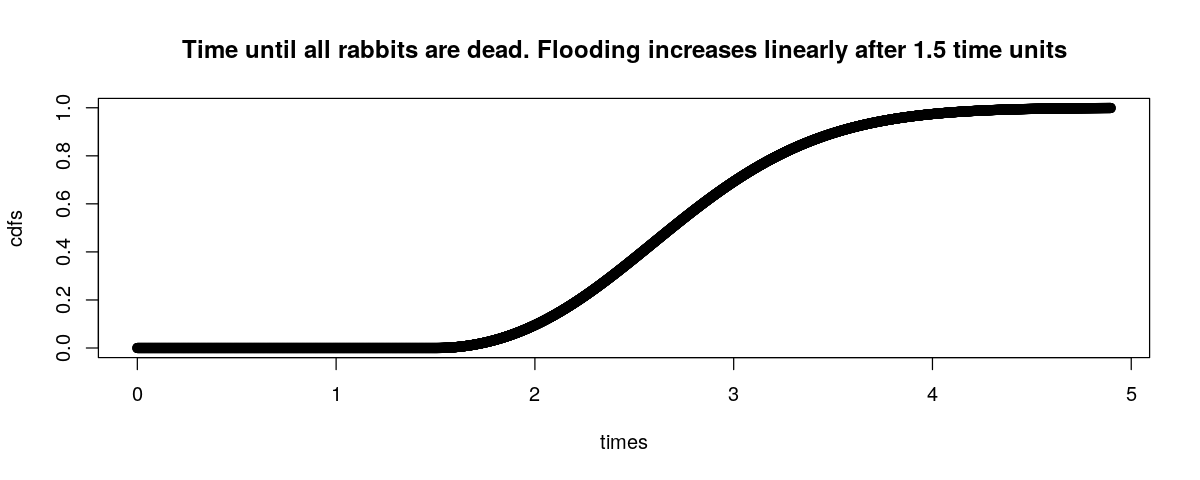

In [ ]:
# If the weights change over time - or new edges are added!
# Then the distribution is time inhomogeneous. The api also
# supports such distributions, but in limited manner.

# Like the pph, dph, etc. functions, it is a (very good) approximation based
# on very small steps. If the rates change dramatically, set the granularity
# as an argument to the functions!! E.g. set it to a high enough value.

# If we pick a time far into the future, we can integrate under the pdf to find the expectation!
cat(paste("Integrating over accumulated visiting time:",sum(accumulated_visiting_time(graph, 10))))
cat(paste("\nThe first moment (expectation):", expectation(graph)))

# Say at a certain point in time, the flooding starts!
# In the beginning, there is *no* flooding
graph_update_weights_parameterized(param_graph, c(1, 0, 0))

# We can build a context to step over the distribution.
# Weights can be freely changed and edges added in such a context
ctx = distribution_context(param_graph)
cdfs <- c()
times <- c()

while (distribution_context_state(ctx)$time < 1.5) {
    cdfs <- c(cdfs, distribution_context_state(ctx)$cdf)
    times <- c(times, distribution_context_state(ctx)$time)
    distribution_context_step(ctx)
}

# At time 1.5, the flooding starts! It increases by every time step!
graph_update_weights_parameterized(param_graph, c(1, 0, 0))

while (distribution_context_state(ctx)$cdf < 0.999) {
    cdfs <- c(cdfs, distribution_context_state(ctx)$cdf)
    times <- c(times, distribution_context_state(ctx)$time)
    graph_update_weights_parameterized(
        param_graph, c(1,
                       (distribution_context_state(ctx)$time - 1.5), 
                       2*(distribution_context_state(ctx)$time - 1.5)
                      )
    )
    distribution_context_step(ctx)
}

plot(times, cdfs)
title("Time until all rabbits are dead. Flooding increases linearly after 1.5 time units")


In [ ]:
# If we pick a time far into the future, we can integrate under it to find the expectation!
# This means that we can scale by a reward, and thereby find the marginal expectation
cat(paste("Summing over accumulated visiting time (with reward):",
            sum(accumulated_visiting_time(graph, 10)*states(graph)[,2])))
cat(paste("\nThe first moment (expectation) (with reward):", expectation(graph,states(graph)[,2])))

# But if the time is *not* far into the future, we get the expectation up to a certain
# point in time!

cat(paste("\nExpectation (rewarded) when truncating at 0.05 time:",
            sum(accumulated_visiting_time(graph, 0.05)*states(graph)[,2])))
cat(paste("\nUntruncated expectation:", expectation(graph,states(graph)[,2])))

cat(paste("\nExpectation (rewarded) when *starting* at 0.05 time:",
            sum(stop_probability(graph, 0.05)*expected_waiting_time(graph, states(graph)[,2]))))

cat(paste("\nSubtracting these gives the *same* value:",
            expectation(graph,states(graph)[,2])-
           sum(stop_probability(graph, 0.05)*expected_waiting_time(graph, states(graph)[,2]))))

cat(paste("\nWe can increase granularity for better performance:",
           sum(accumulated_visiting_time(graph, 0.05, granularity=1000000)*states(graph)[,2])))
# However, if there are sudden, single, large changes,
# we can also just get the chunked expectation by subtracting

Summing over accumulated visiting time (with reward): 0.0943877550988707
The first moment (expectation) (with reward): 0.0943877551020408
Expectation (rewarded) when truncating at 0.05 time: 0.00117132349857445
Untruncated expectation: 0.0943877551020408
Expectation (rewarded) when *starting* at 0.05 time: 0.0932581146642645
Subtracting these gives the *same* value: 0.00112964043777626
We can increase granularity for better performance: 0.00111383178979534

## Fast state-space construction through C api

In [ ]:
# While the R api can create graphs, this is *slow* as the C++ binding layer
# through Rcpp is slow when invoking many functions, and since R is a slow,
# interpreted language
# Clone or download the code, and include these files in the repository!
# Make SURE that the version of the downloaded code is the same as the
# installed R library!! Otherwise it may crash randomly
# The file has comments and is easy to understand, so you should be able
# to defined you own cool construction functions

Rcpp::sourceCpp("./rabbit_construction_c.cpp")

In [ ]:
# The included file (open it for youself and see!) defined a function construct_rabbit_graph
graph <- construct_rabbit_graph(2, 2, 4)

cat("See how the graph is identical to the R construction?\n")
graph_as_matrix(graph)$SIM

# We can very fast build large state spaces!!
large <- construct_rabbit_graph(500, 2, 4)
cat(paste("Vertices:", vertices_length(large)))

# Don't worry about speed when invoking the other api functions
# they are not slower as we invoke one C function once and wait
# for it to return!
cat(paste("\nExpectation:", expectation(large)))

See how the graph is identical to the R construction?


-5,1,0,0,0
1,-8,1,4,2
0,1,-3,0,0
0,0,0,-3,1
0,0,0,1,-5


Vertices: 125752
Expectation: 0.536563856879033

## Numerical accuracy

In [ ]:
# To prove that the algorithms are numerically accuracy, we will compare against
# a baseline by matrix equations.
# We build an 100% dense graph, and compare the results
set.seed(1234)
VERTICES <- 1000

g <- create_graph(0)
vertices <- list()
for (i in 1:VERTICES) {
    vertices[[i]] <- create_vertex(g, 0)
}

add_edge(starting_vertex(g), vertices[[1]], 1)
for (i in 1:(VERTICES-1)) {
    for (j in 1:VERTICES) {
        if (i==j) {
            next();
        }
        
        weight <- runif(1)
        add_edge(vertices[[i]],vertices[[j]], weight)
        }
    }

# Matrix equations for 3rd moment
GAM <- graph_as_matrix(g)
U <- -solve(GAM$SIM)
S <- GAM$SIM
s <- -rowSums(S)
alpha <- GAM$IPV
e <- rep(1, length(GAM$IPV))

df <- data.frame()
MAT <- U
for (k in 1:10) {
    v <- factorial(k)*alpha %*% MAT %*% e 
    #integrating_under_curve <- sum(
     #   dph(seq(0,100,by=0.01), g)*(seq(0,100,by=0.01)^k)
     #   /10000)
    df <- rbind(df, list(moment=k, matrix_based=round(v,10),
                         ptdalgorithms_moment=round(moments(g, k)[k],10)
                #ptdalgorithms_integrating_under_curve=integrating_under_curve
               ))
    MAT <- U %*% MAT
}
df

moment,matrix_based,ptdalgorithms_moment
<int>,<dbl>,<dbl>
1,2.033952e+00,2.033952e+00
2,8.281555e+00,8.281555e+00
3,5.057951e+01,5.057951e+01
4,4.118851e+02,4.118851e+02
5,4.192640e+03,4.192640e+03
6,5.121301e+04,5.121301e+04
7,7.298269e+05,7.298269e+05
8,1.188643e+07,1.188643e+07
9,2.177887e+08,2.177887e+08


In [ ]:
install.packages("expm")
library(expm)

Installing package into ‘/home/tobias/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Warning message in install.packages("expm"):
“installation of package ‘expm’ had non-zero exit status”


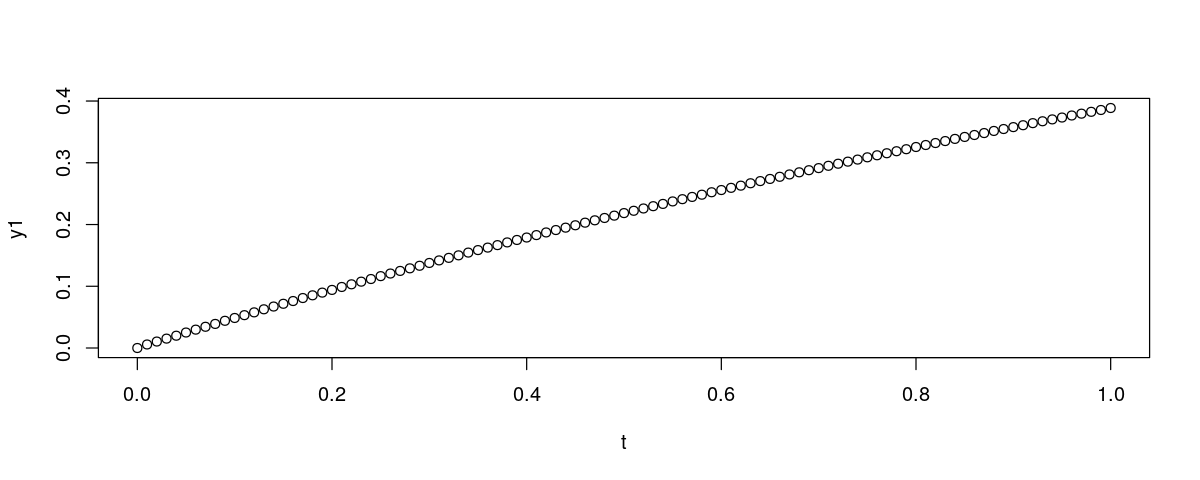

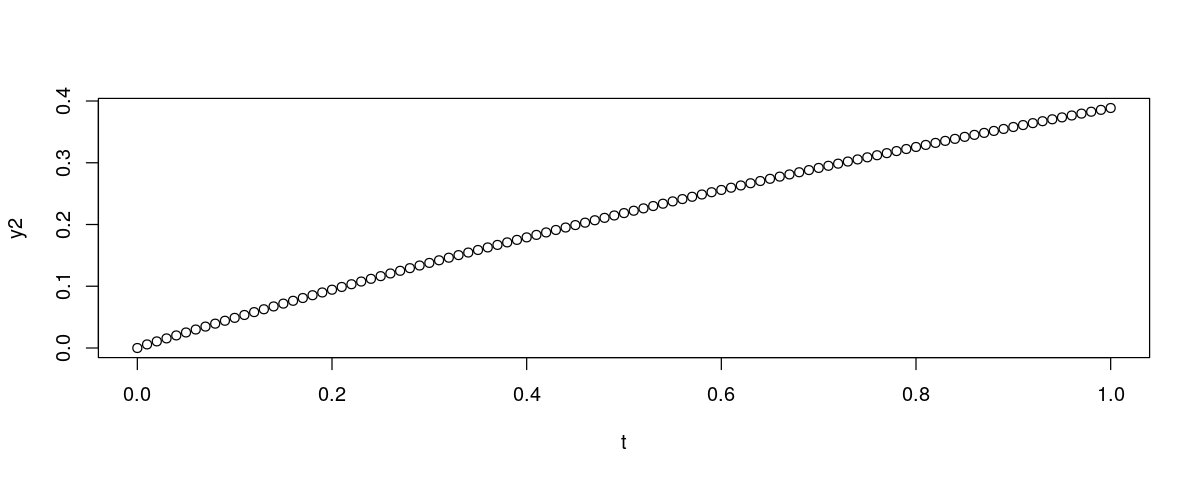

In [ ]:
t <- seq(0,1,by=0.01)
y1 <- pph(t,g,granularity=10000)
plot(t, y1)
y2 <- sapply(t, function(t) {1-alpha%*%expm(S*t)%*%e})
plot(t, y2)

In [ ]:
mean(abs((y2-y1)/y1)*100, na.rm=T)
max(abs((y2-y1)/y1)*100, na.rm=T)

[1] 0.002748115

[1] 0.02092957

[1] 0.5

In [ ]:
stop1 <- alpha%*%expm(S)
stop2 <- stop_probability(g, 1, 10000)

In [ ]:
stop11 <- c(0, rev(stop1),0)
mean(abs(stop11-stop2)/stop11*100, na.rm=T)
max(abs(stop11-stop2)/stop11*100, na.rm=T)

[1] 0.00120642

[1] 0.00120642